# Handwritten optical character recognition 

--- 


<br>


In [61]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [62]:


# import other libraries
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.image as implt
from IPython.display import clear_output as cls

In [63]:
# import all tensorflow related libraries
import tensorflow as tf



In [64]:
import tensorflow.data as tfd
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [65]:
IMG_WIDTH = 200
IMG_HEIGHT = 50
IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)
BATCH_SIZE = 16
EPOCHS = 100
LEARNING_RATE = 1e-3
MODEL_NAME = "CharacterRecognition-Model"
TRAIN_SIZE = BATCH_SIZE * 3000
VALID_SIZE = BATCH_SIZE * 1500
TEST_SIZE  = BATCH_SIZE * 300
AUTOTUNE = tfd.AUTOTUNE


# Paths 
train_csv_path = '/kaggle/input/handwriting-recognitionocr/CSV/written_name_train.csv'


valid_csv_path = '/kaggle/input/handwriting-recognitionocr/CSV/written_name_validation.csv'
test_csv_path = '/kaggle/input/handwriting-recognitionocr/CSV/written_name_test.csv'
train_image_dir = '/kaggle/input/handwriting-recognitionocr/train_v2/train'
valid_image_dir = '/kaggle/input/handwriting-recognitionocr/validation_v2/validation'
test_image_dir = '/kaggle/input/handwriting-recognitionocr/test_v2/test'

# SetUp random seeds for numpy and TensorFlow
np.random.seed(2569)
tf.random.set_seed(2569)

In [66]:
# load the csv files 
train_csv = pd.read_csv(train_csv_path)[:TRAIN_SIZE]
test_csv = pd.read_csv(test_csv_path)[:TEST_SIZE]
valid_csv = pd.read_csv(valid_csv_path)[:VALID_SIZE]

In [67]:
train_csv.head()

,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON
2,TRAIN_00003.jpg,BENES
3,TRAIN_00004.jpg,LA LOVE
4,TRAIN_00005.jpg,DAPHNE


### Load the train labels 


In [68]:
# get the train labels 
train_labels = [str(word) for word in train_csv["IDENTITY"].to_numpy()]

In [69]:
# extract all the unique characters
unique_characters = set(char for word in train_labels for char in word)
# define the number of classes (for labels) based on the number of unique characters
n_classes = len(unique_characters)

In [70]:
print(f"Number of unique classes(unique characters): {n_classes}")

Number of unique classes(unique characters): 45


In [71]:
# get the maximum length that a label can have 
MAX_LABEL_LENGTH = max(map(len, train_labels))

In [72]:
print(f"The length of the longest label in the datase: {MAX_LABEL_LENGTH}")

The length of the longest label in the datase: 34


In [73]:
train_csv['FILENAME'] = [train_image_dir + f"/{filename}" for filename in train_csv['FILENAME']]
valid_csv['FILENAME'] = [valid_image_dir + f"/{filename}" for filename in valid_csv['FILENAME']]
test_csv['FILENAME']  = [test_image_dir + f"/{filename}" for filename in test_csv['FILENAME']]

In [74]:
train_csv.head()

,FILENAME,IDENTITY
0,/kaggle/input/handwriting-recognitionocr/train...,BALTHAZAR
1,/kaggle/input/handwriting-recognitionocr/train...,SIMON
2,/kaggle/input/handwriting-recognitionocr/train...,BENES
3,/kaggle/input/handwriting-recognitionocr/train...,LA LOVE
4,/kaggle/input/handwriting-recognitionocr/train...,DAPHNE


## Label preprocessing



In [75]:
# Char to Num
char_to_num = StringLookup(vocabulary=list(unique_characters), mask_token=None)
num_to_char = StringLookup(vocabulary = char_to_num.get_vocabulary(), mask_token = None, invert = True)

In [76]:
len(char_to_num.get_vocabulary())+1

47

## Image preprocessing 
**To Function must be used for image preprocessing part:** <br>


In [77]:
def load_image(image_path):
   
    # read the image
    image = tf.io.read_file(image_path)
    # decode the image
    decoded_image = tf.image.decode_jpeg(contents=image, channels=1)
    # convert image data type to float32
    convert_imgs = tf.image.convert_image_dtype(image=decoded_image, dtype=tf.float32)
    # resize and transpose 
    resized_image = tf.image.resize(images=convert_imgs, size=(IMG_HEIGHT, IMG_WIDTH))
    image = tf.transpose(resized_image, perm = [1, 0, 2])

    # to numpy array (Tensor)
    image_array = tf.cast(image, dtype=tf.float32)

    return image_array

In [78]:
def encode_single_sample(image_path, label:str):
    
    
    
    # Get the image
    image = load_image(image_path)
    # Convert the label into characters
    chars = tf.strings.unicode_split(label, input_encoding='UTF-8')
    # Convert the characters into vectors
    vecs = char_to_num(chars)
    
    # Pad label
    pad_size = MAX_LABEL_LENGTH - tf.shape(vecs)[0]
    vecs = tf.pad(vecs, paddings = [[0, pad_size]], constant_values=n_classes+1)
    
    return {'image':image, 'label':vecs}

In [79]:
# Training Data
train_ds = tf.data.Dataset.from_tensor_slices(
    (np.array(train_csv['FILENAME'].to_list()), np.array(train_csv['IDENTITY'].to_list()))
).shuffle(1000).map(encode_single_sample, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Validation data
valid_ds = tf.data.Dataset.from_tensor_slices(
    (np.array(valid_csv['FILENAME'].to_list()), np.array(valid_csv['IDENTITY'].to_list()))
).map(encode_single_sample, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Testing data.
test_ds = tf.data.Dataset.from_tensor_slices(
    (np.array(test_csv['FILENAME'].to_list()), np.array(test_csv['IDENTITY'].to_list()))
).map(encode_single_sample, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [80]:
# check the data distribution 
print(f"Training Data Size   : {tf.data.Dataset.cardinality(train_ds).numpy() * BATCH_SIZE}")
print(f"Validation Data Size : {tf.data.Dataset.cardinality(valid_ds).numpy() * BATCH_SIZE}")
print(f"Testing Data Size    : {tf.data.Dataset.cardinality(test_ds).numpy() * BATCH_SIZE}")

Training Data Size   : 48000
Validation Data Size : 24000
Testing Data Size    : 4800


### Explore the dataset 
See some images 

In [81]:
def show_images(data, GRID=[4,4], FIGSIZE=(25, 8), cmap='binary_r', model=None, decode_pred=None):
    
    # Plotting configurations
    plt.figure(figsize=FIGSIZE)
    n_rows, n_cols = GRID
    
    # Loading Data 
    data = next(iter(data))
    images, labels = data['image'], data['label']
    
    # Iterate over the data 
    for index, (image, label) in enumerate(zip(images, labels)):
        
        # Label processing
        text_label = num_to_char(label)
        text_label = tf.strings.reduce_join(text_label).numpy().decode('UTF-8')
        text_label = text_label.replace("[UNK]", " ").strip()
        
        # Create a sub plot
        plt.subplot(n_rows, n_cols, index+1)
        plt.imshow(tf.transpose(image, perm=[1,0,2]), cmap=cmap)
        plt.axis('off')
        
        if model is not None and decode_pred is not None:
            # Make prediction
            pred = model.predict(tf.expand_dims(image, axis=0))
            pred = decode_pred(pred)[0]
            title = f"True : {text_label}\nPred : {pred}"
            plt.title(title)
        else:
            # add title
            plt.title(text_label)

    # Show the final plot
    cls()
    plt.show()

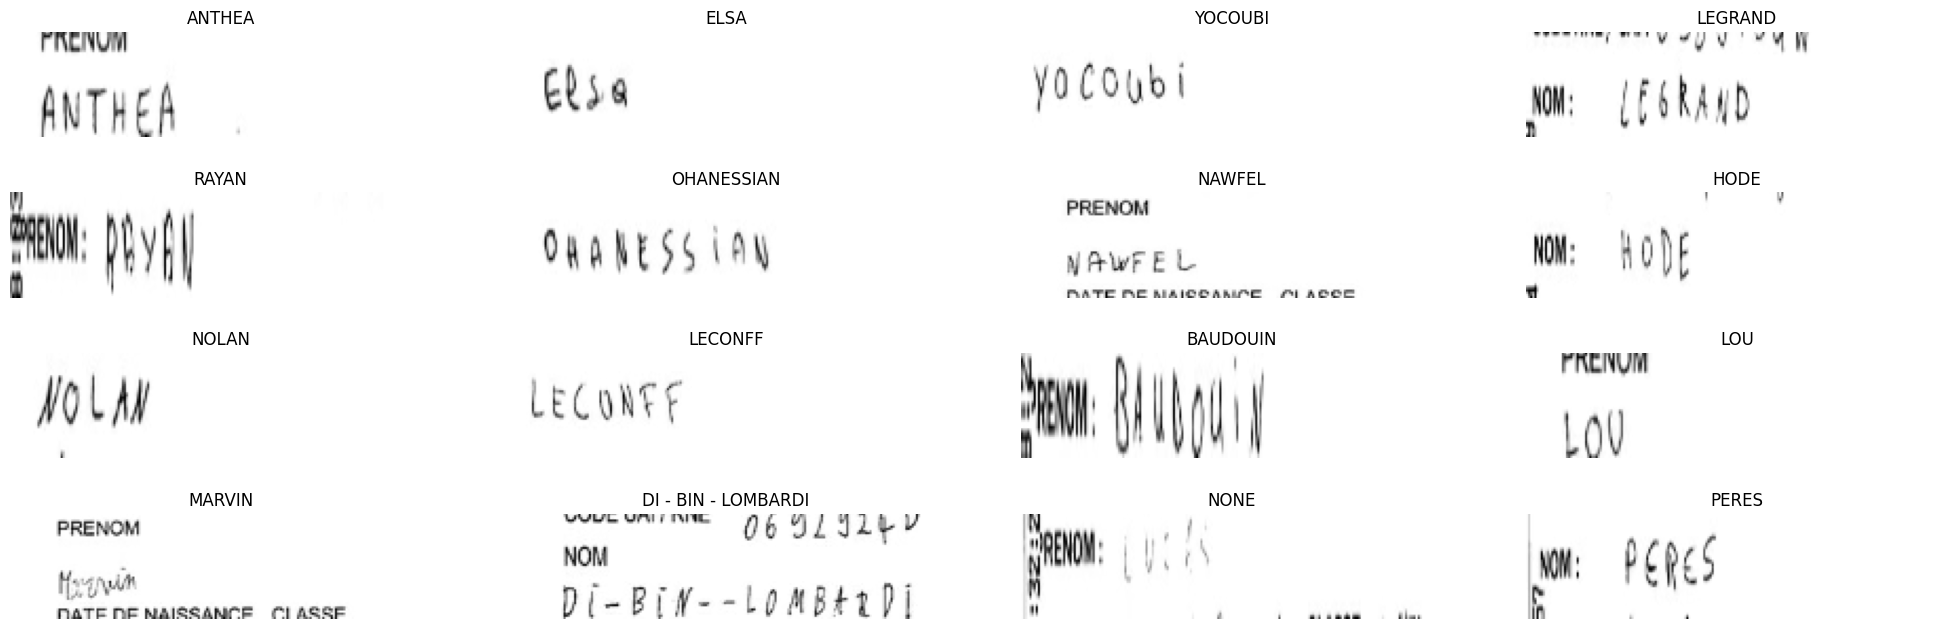

In [82]:
show_images(data=train_ds, cmap='gray')

In [83]:
class CTCLayer(Layer):
    def __init__(self, **kwargs) -> None:
        super().__init__(**kwargs)

        # define the loss function 
        self.loss_function = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_hat):
        # Get the batch length 
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")

        # get the input and label lengths
        input_len = tf.cast(tf.shape(y_hat)[1], dtype='int64') * tf.ones(shape=(batch_len, 1), dtype='int64')
        label_len = tf.cast(tf.shape(y_true)[1], dtype='int64') * tf.ones(shape=(batch_len, 1), dtype='int64')

        # calculate the loss
        loss = self.loss_function(y_true, y_hat, input_len, label_len) 

        self.add_loss(loss)

        return y_hat

In [84]:
# Input Layer
input_images = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 1), name="image")

# Labels : These are added for the training purpose.
input_labels = Input(shape=(None, ), name="label")

### Convolutional layers
# layer 1 
conv_1 = Conv2D(64, 3, strides=1, padding="same", kernel_initializer="he_normal", activation="relu", name="conv_1")(input_images)
# layer 2
conv_2 = Conv2D(32, 3, strides=1, padding="same", kernel_initializer="he_normal", activation="relu", name="conv_2")(conv_1)
max_pool_1 = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(conv_2)
# layer 3
conv_3 = Conv2D(64, 3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal', name="conv_3")(max_pool_1)
conv_4 = Conv2D(32, 3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal', name="conv_4")(conv_3)
max_pool_2 = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(conv_4)



### Encoding 
reshape = Reshape(target_shape=((IMG_WIDTH//4), (IMG_HEIGHT//4)*32), name="reshape_layer")(max_pool_2)
dense_encoding = Dense(64, kernel_initializer="he_normal", activation="relu", name="enconding_dense")(reshape)
dense_encoding_2 = Dense(64, kernel_initializer="he_normal", activation="relu", name="enconding_dense_2")(dense_encoding)
dropout = Dropout(0.4)(dense_encoding_2)

# Decoder
lstm_1 = Bidirectional(LSTM(128, return_sequences=True, dropout=0.25), name="bidirectional_lstm_1")(dropout)
lstm_2 = Bidirectional(LSTM(64, return_sequences=True, dropout=0.25), name="bidirectional_lstm_2")(lstm_1)

# Final Output layer
output = Dense(len(char_to_num.get_vocabulary())+1, activation="softmax", name="output_dense")(lstm_2)

# Add the CTC loss 
ctc_loss_layer = CTCLayer()(input_labels, output) 

# Define the final model
model = Model(inputs=[input_images, input_labels], outputs=[ctc_loss_layer])

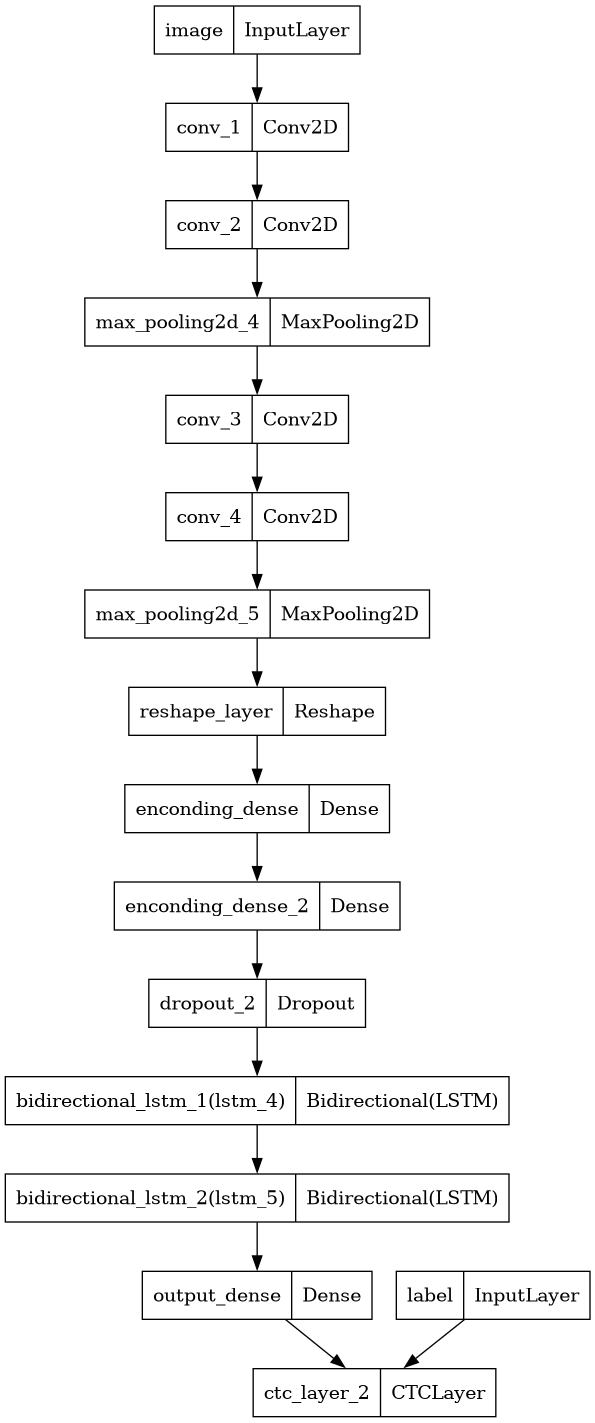

In [85]:
# draw the model plot
tf.keras.utils.plot_model(
    model,
    to_file='model-graph.png'
)

In [86]:
# see the model summary 
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 200, 50, 1)]         0         []                            
                                                                                                  
 conv_1 (Conv2D)             (None, 200, 50, 64)          640       ['image[0][0]']               
                                                                                                  
 conv_2 (Conv2D)             (None, 200, 50, 32)          18464     ['conv_1[0][0]']              
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 100, 25, 32)          0         ['conv_2[0][0]']              
 g2D)                                                                                       

### Model Training 

In [87]:
# compile the model
model.compile(optimizer="adam")

In [88]:
# train the model
history = model.fit(train_ds, validation_data=valid_ds, epochs=EPOCHS)

Epoch 1/100
3000/3000 [==============================] - 118s 36ms/step - loss: 19.5514 - val_loss: 18.5130
Epoch 2/100
3000/3000 [==============================] - 107s 36ms/step - loss: 18.3135 - val_loss: 17.9502
Epoch 3/100
3000/3000 [==============================] - 107s 36ms/step - loss: 16.5333 - val_loss: 14.2495
Epoch 4/100
3000/3000 [==============================] - 107s 36ms/step - loss: 11.6849 - val_loss: 8.4754
Epoch 5/100
3000/3000 [==============================] - 108s 36ms/step - loss: 7.7952 - val_loss: 6.4268
Epoch 6/100
3000/3000 [==============================] - 107s 36ms/step - loss: 6.0784 - val_loss: 4.6153
Epoch 7/100
3000/3000 [==============================] - 109s 36ms/step - loss: 4.3358 - val_loss: 3.3363
Epoch 8/100
3000/3000 [==============================] - 109s 36ms/step - loss: 3.4804 - val_loss: 2.7946
Epoch 9/100
3000/3000 [==============================] - 107s 36ms/step - loss: 3.0179 - val_loss: 2.5338
Epoch 10/100
3000/3000 [===============

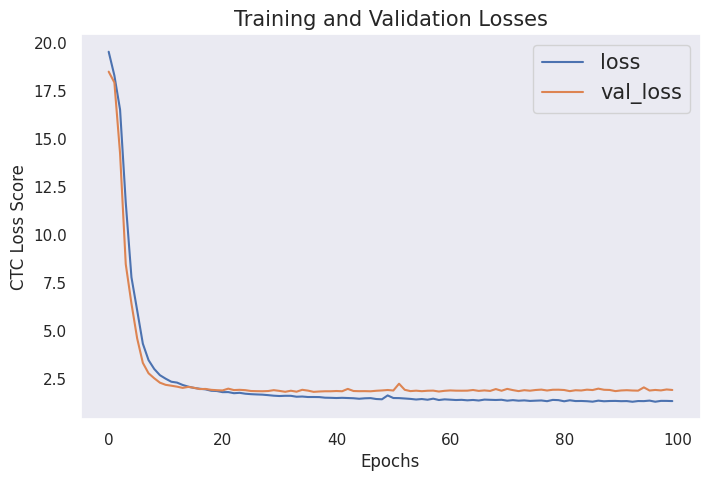

In [89]:
import seaborn as sb
# draw plot for results 
sb.set()
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.legend(fontsize=15)
plt.xlabel("Epochs")
plt.ylabel("CTC Loss Score")
plt.title("Training and Validation Losses", fontsize=15)
plt.grid()
plt.savefig("model_result.png")
plt.show()

## Testing and Evaluation

In [99]:
# evaluate the model on the test dataset 
evaluation = model.evaluate(test_ds)
print(f"evaluation loss: {evaluation}")

300/300 [==============================] - 6s 20ms/step - loss: 1.9697
evaluation loss: 1.9696764945983887


In [100]:
def decoder_prediction(pred_label):
    
    # Input length
    input_len = np.ones(shape=pred_label.shape[0]) * pred_label.shape[1]
    
    # CTC decode
    decode = tf.keras.backend.ctc_decode(pred_label, input_length=input_len, greedy=True)[0][0][:,:MAX_LABEL_LENGTH]
    
    # Converting numerics back to their character values
    chars = num_to_char(decode)
    
    # Join all the characters
    texts = [tf.strings.reduce_join(inputs=char).numpy().decode('UTF-8') for char in chars]
    
    # Remove the unknown token
    filtered_texts = [text.replace('[UNK]', " ").strip() for text in texts]
    
    return filtered_texts

In [101]:
# define a model for testing and evaluation 
pred_model = Model(inputs=model.get_layer(name="image").input, outputs=model.get_layer(name='output_dense').output)

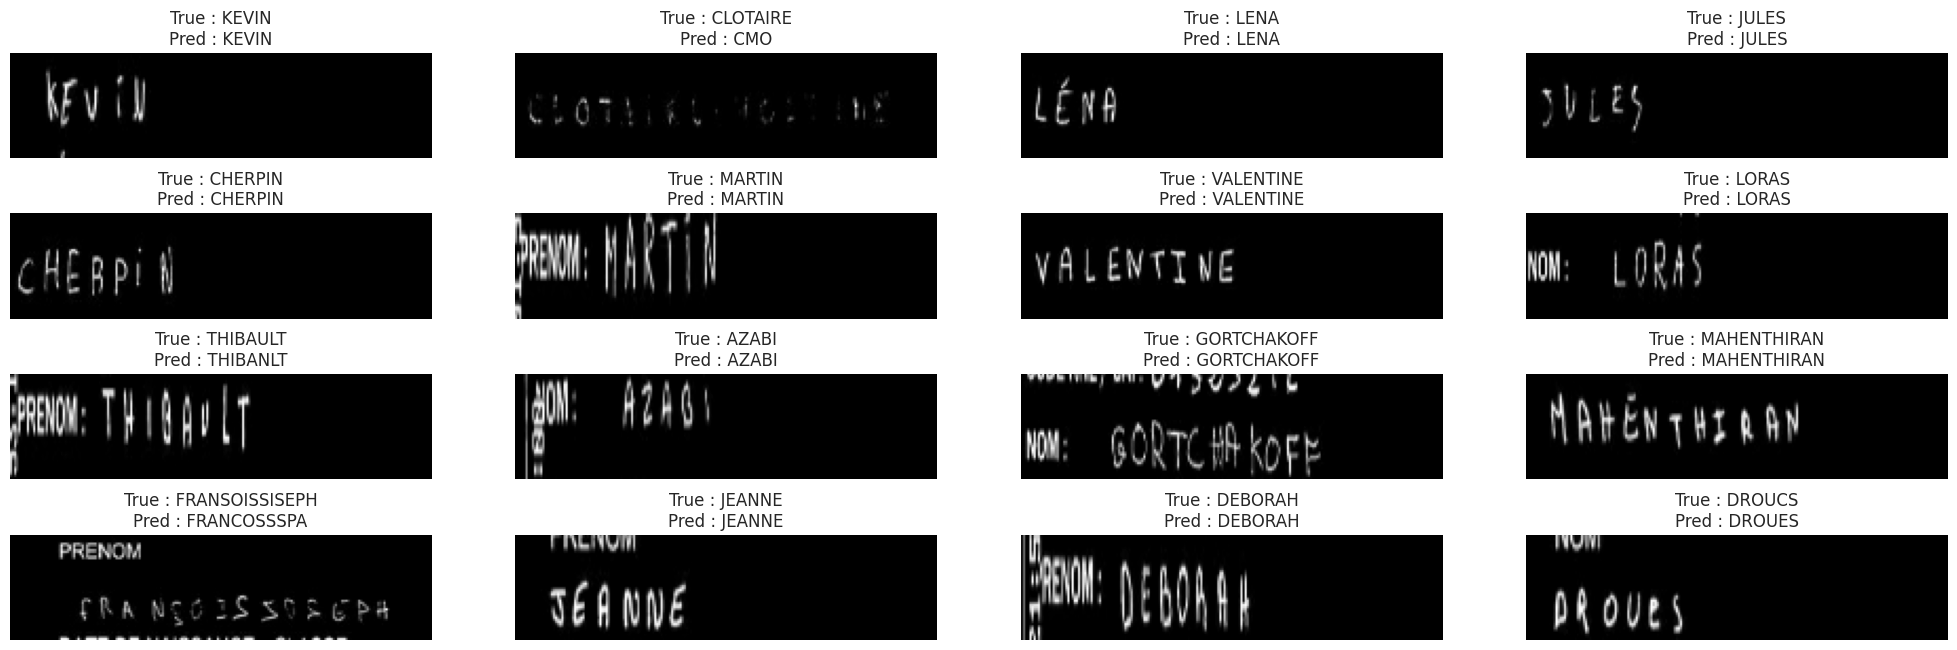

In [102]:
show_images(data=test_ds, model=pred_model, decode_pred=decoder_prediction, cmap='binary')

### Single Sample prediction with my own ip

In [110]:
def single_sample_prediction(model, path):
    
    # load image 
    image_loading = tf.io.read_file(path)
    # decode image 
    decoded_image = tf.image.decode_jpeg(contents=image_loading, channels=1)
    # convert the image data type to float 
    convert_image = tf.image.convert_image_dtype(image=decoded_image, dtype=tf.float32)
    # resize the image 
    resized_image = tf.image.resize(images=convert_image, size=(IMG_HEIGHT, IMG_WIDTH))
    resized_image = tf.transpose(resized_image, perm = [1, 0, 2])
    # convert image to array
    image_array = tf.cast(resized_image, dtype=tf.float32)
    # reshape image 
    single_image_data_with_batch = np.expand_dims(image_array, axis=0)

    # make prediction 
    prediction = decoder_prediction(model.predict(single_image_data_with_batch))

    return prediction 

1/1 [==============================] - 0s 23ms/step
['AZABI']


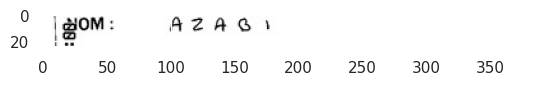

In [119]:
# prediction 1:
img_1_path = '/kaggle/input/handwriting-recognitionocr/test_v2/test/TEST_0010.jpg'
img_1 = implt.imread(img_1_path)
plt.imshow(img_1)
print(single_sample_prediction(pred_model, img_1_path))

1/1 [==============================] - 0s 23ms/step
['AZABI']


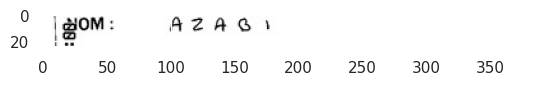

In [117]:
# prediction 2:
img_2_path = '/kaggle/input/handwriting-recognitionocr/test_v2/test/TEST_0010.jpg'
img_2 = implt.imread(img_2_path)
plt.imshow(img_2)
print(single_sample_prediction(pred_model, img_2_path))

1/1 [==============================] - 0s 22ms/step
['MAHENTHIRAN']


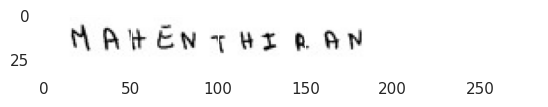

In [115]:
# prediction 3:
img_3_path = '/kaggle/input/handwriting-recognitionocr/test_v2/test/TEST_0012.jpg'
img_3 = implt.imread(img_3_path)
plt.imshow(img_3)
print(single_sample_prediction(pred_model, img_3_path))

### Saving the model

In [ ]:
# save the model
model.save("model.hd5")
# save weights
model.save_weights("model_weights.hd5")